In [225]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
import seaborn as sns
from tqdm.notebook import tqdm
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.patches as mpatches

# **Problem description**

Simple model $x = \theta + \epsilon \ \text{with}\ \epsilon\sim \mathcal{N}(0 ; \sigma^{2})\ ; \ \sigma^{2} = 0.01 \\$
Prior on theta
$$ p(\theta) = \mathcal{N}(\mu_0,\,\sigma_0^2)$$
Posterior
$$p(\theta \mid x) = \mathcal{N}(m,\,s^2)$$
$$m = \left(\frac{\frac{\mu_0}{\sigma_0^2} + \frac{x}{\sigma^2}}{\frac{1}{\sigma_0^2} + \frac{1}{\sigma^2}}\right)
\ \text{ and } \ s^{2} = \left(\frac{1}{\sigma_0^2} + \frac{1}{\sigma^2} \right)^{-1}$$


But suppose we only have $$\mathcal{D} = \{(\theta_i, x_i)\} \ \text{with} \ $$
$$\begin{aligned}
\theta_i &\sim p(\theta) \\
x_i &\sim p(x \mid \theta_i) \\
(\theta_i, x_i) &\sim p(\theta, x) = p(\theta) p(x \mid \theta)
\end{aligned}$$
We are looking for a function f, such that
$ \theta = f(x,z) = \alpha z + (\beta x + \gamma) $ with $z \sim \mathcal{N}(0 ; 1) $ and x the context. The parameters are estimated by minimising the forward Kullback-Leibler divergence, that is $$arg(min_{\phi} (L(\alpha,\beta,\gamma)) ) = arg\min_{\phi}\mathbb{E}_{x}\left[KL(p(\theta \mid x)\vert \vert q_{\phi}(\theta \mid x)) \right] \\
 \approx - \frac{1}{N} \sum_{i=1}^{N} \log(q_{\phi}(\theta_i \mid x_i)) \; (\theta_i, x_i) \sim p(\theta, x); \\
 \phi = (\alpha;\beta;\gamma)$$

In [226]:
sigma = 0.1 #sigma²=0.01
mu0 = 42 #Prior mean
sigma0 = 2 #Prior std
#Putting them into tensors
sigma_T = torch.Tensor([sigma])
mu0_T = torch.Tensor([mu0])
sigma0_T = torch.Tensor([sigma0])
base_distribution = torch.distributions.Normal(torch.Tensor([0.0]), torch.Tensor([1.0]))

In [227]:
def data_generating_process(N:int):
    """Generate a tensor of x and thetas generated according to
    x = theta + epsilon; espilon ~N(0;sigma0)

    Args:
        N (int): Length of the dataset

    Returns:
        torch.Tensor : Tensor with x in the first columns and thetas in the 2nd one
    """
    res = torch.Tensor( N, 2) 
    thetas = torch.distributions.Normal(mu0_T, sigma0_T).sample((N, 1)) #Prior
    epsilons = torch.distributions.Normal(torch.Tensor([0]), sigma_T).sample((N, 1)) #Gaussian noise
    x = thetas + epsilons #Simulator
    res[:,0] = x.squeeze()
    res[:,1] = thetas.squeeze()
    return res

def simulator(N):
    """Simulator. Sample theta_i from p(theta) and simulates xi from p(x|theta)

    Args:
        N (int): Number of simulations to run

    Returns:
        torch.Tensor: Tensor with x in the first columns and thetas in the 2nd one
    """
    res = torch.Tensor(N, 2)
    thetas = torch.distributions.Normal(mu0_T, sigma0_T).sample((N, 1))
    epsilons = torch.distributions.Normal(torch.Tensor([0]), sigma_T).sample((N, 1))
    x = thetas + epsilons 
    res[:, 0] = x.squeeze()
    res[:, 1] = thetas.squeeze()
    return res

#Running the simulation 
D = simulator(1000)
print(D)
x, thetas = D[:,0], D[:,1]
D_test = simulator(100)
thetas_test, x_test = D_test[:,0], D_test[:,1]

true_data = data_generating_process(1000)
true_x, true_thetas = true_data[:,0], true_data[:,1]

tensor([[45.1330, 45.0472],
        [38.4738, 38.5088],
        [45.4982, 45.5244],
        ...,
        [42.2593, 42.3873],
        [42.8774, 42.9294],
        [39.9946, 39.9798]])


In [228]:
class Prior():
    
    def __init__(self, mu_0, sigma_0):
        self.mu_0 = mu_0
        self.sigma_0 = sigma_0
        self.dist = torch.distributions.Normal(self.mu_0, self.sigma_0)
    
    def sample(self, N):
        return self.dist.sample((N, 1))
    
class Likelihood():
    
    def __init__(self, sigma):
        self.std = sigma
    def sample(self, theta:torch.Tensor,N):
        mu = theta
        std = self.std
        sample = torch.distributions.Normal(mu, std).sample((N, 1))
        return sample

In [229]:
    class flow(nn.Module):
        
        def __init__(self,base, omega=None, beta=None, gamma=None):
            """Initialise the function, parametrised by exp(omega), beta and gamma
            f(x, z) = exp(omega)*z +  beta*x + gamma

            Args:
                base (torch.distributions): Base distribution, simple to sample from
                omega (float, optional): Defaults to None.
                beta (float, optional): Defaults to None.
                gamma (float, optional): Defaults to None.
            """
            super(flow, self).__init__()
            
            if omega is None:
                omega = torch.distributions.Uniform(-1.0,1.0).sample((1, ))
            self.omega = nn.Parameter(torch.Tensor([omega]), requires_grad=True)
            
            if beta is None:
                beta = torch.distributions.Uniform(-1.0,1.0).sample((1, ))
            self.beta = nn.Parameter(torch.Tensor([beta]), requires_grad= True)
            
            if gamma is None:
                gamma = torch.distributions.Uniform(-1.0,1.0).sample((1, ))
            self.gamma = nn.Parameter(torch.Tensor([gamma]), requires_grad= True)
            
            self.base = base

            
        def forward(self, x):
            """Compute the forward f(x, z) = exp(omega)*z + beta*x+gamma = theta and returns theta

            Args:
                x (torch.Tensor): Context

            Returns:
                torch.Tensor: f(x, z)
            """
            z = self.base.sample(x.size())
            theta = torch.exp(self.omega)*z + self.beta * x + self.gamma
            return theta
        
        def loss(self, thetas, X):
            """Computes the loss corresponding to the forward KL-divergence
            q(theta | x) = density of N(beta*x+gamma; alpha²)
            loss = - 1/N *sigma(log(q(theta_i | x_i)))
            Args:
                thetas (torch.Tensor)
                X (torch.Tensor)

            Returns:
                float: Corresponding loss
            """
            res = 0          
            est_mean = self.beta*X + self.gamma 
            est_std = torch.exp(self.omega)
            logprob = torch.distributions.Normal(torch.Tensor(est_mean), torch.Tensor(est_std)).log_prob(thetas)
            res += logprob.sum()
            
            return -res.mean()
            
        def sample(self, x, size):
            """Sample theta given x according to theta=f(x, z)

            Args:
                x (torch.Tensor): Context
                size (tuple)

            Returns:
                torch.Tensor
            """
            with torch.no_grad():    
                thetas_hat = torch.zeros(size)
                for i in range(size[0]):
                    thetas_hat[i] = self.forward(x)
            return thetas_hat

f = flow(base_distribution,1.0,1.0,1.0)

In [230]:
dataset = TensorDataset(thetas, x)
batch_size = 32
loader = DataLoader(dataset,batch_size,shuffle=True)

In [231]:
n_iter = 5000
learning_rate = 1e-3
optimizer = torch.optim.Adam(f.parameters(), learning_rate)
losses_train = []
epsilon = 1e-4
estimated_alpha = []
estimated_beta = []
estimated_gamma = []
with torch.no_grad():
    previous_loss = f.loss(thetas_test,x_test).mean().detach().item()
counter=1
patience = 2
for i in range(n_iter):
    loss_batch = 0
    for batch_idx, batch in enumerate(loader):
        thetas_i,x_i = batch
        #thetas_hat = f.forward(x_i)###
        #loss_train = f.loss(thetas_hat,x_i)
        loss_train = f.loss(thetas_i,x_i)
        optimizer.zero_grad()
        loss_train.backward()
        optimizer.step()
        loss_batch+= loss_train.detach().item()
    losses_train.append(loss_batch)    
    estimated_alpha.append(torch.exp(f.omega).detach().item())
    estimated_beta.append(f.beta.detach().item())
    estimated_gamma.append(f.gamma.detach().item())
        
    if i%5==0:
        with torch.no_grad():
            loss_test = f.loss(thetas_test,x_test)
            if np.abs(loss_test - previous_loss) < epsilon:
                counter += 1
            if counter == patience:
                print(f"Early stop at iteration {i}")
                break
            previous_loss = loss_test
            
    if i%200==0:
        print(f"Iteration {i} and loss = {loss_train}")


Iteration 0 and loss = 54.656578063964844
Iteration 200 and loss = 2.9587206840515137
Iteration 400 and loss = 1.0920859575271606
Iteration 600 and loss = -0.6066937446594238
Iteration 800 and loss = 6.900995254516602
Iteration 1000 and loss = -4.344807147979736
Iteration 1200 and loss = -6.293212413787842
Iteration 1400 and loss = -7.8978962898254395
Iteration 1600 and loss = -7.8830084800720215
Iteration 1800 and loss = -9.227299690246582
Iteration 2000 and loss = -7.865655422210693
Iteration 2200 and loss = -8.691537857055664
Iteration 2400 and loss = -8.613161087036133
Iteration 2600 and loss = -4.363839149475098
Iteration 2800 and loss = -5.41359806060791
Iteration 3000 and loss = -4.591598987579346
Iteration 3200 and loss = -5.5291266441345215
Iteration 3400 and loss = -9.645135879516602
Iteration 3600 and loss = -9.36917495727539
Iteration 3800 and loss = -8.617782592773438
Iteration 4000 and loss = -7.555357933044434
Iteration 4200 and loss = -8.80998706817627
Iteration 4400 an

In [232]:
C = (   mu0/(sigma0**2)  ) * ( 1/sigma0**2 + 1/sigma**2  )**(-1)
B = ( 1/sigma**2 ) * (1/sigma**2 + 1/sigma0**2 )**(-1)
A = ( 1/sigma0**2 + 1/sigma**2)**(-1/2)
alpha_inf = mu0**2 + (1 + (sigma0/sigma)**2 ) * (A**2)
#TODO Vérifier la CV de alpha, ce ne doit pas être A plutôt ? 

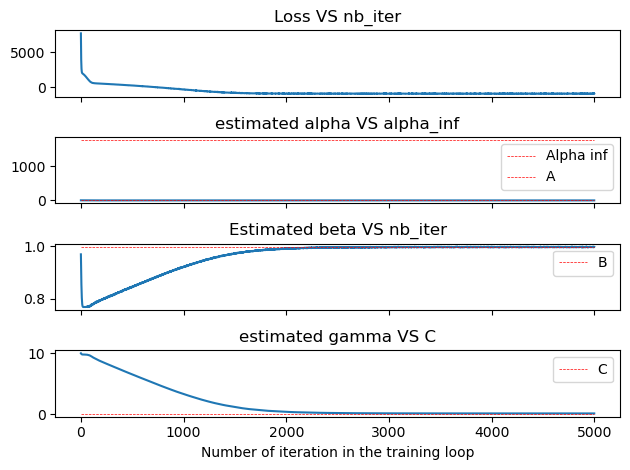

In [233]:
fig, axs = plt.subplots(4, sharex = True)
axs[0].plot(losses_train)
axs[0].set_title("Loss VS nb_iter")
axs[1].plot(estimated_alpha)
axs[1].hlines(y=alpha_inf,xmin=0, xmax=n_iter, linewidth=0.5, color='r', label="Alpha inf", linestyles='dashed')
axs[1].hlines(y=A,xmin=0, xmax=n_iter, linewidth=0.5, color='r', label="A", linestyles='dashed')
axs[1].legend()
axs[1].set_title("estimated alpha VS alpha_inf")
axs[2].plot(estimated_beta)
axs[2].hlines(y=B,xmin=0, xmax=n_iter, linewidth=0.5, color='r', label="B", linestyles='dashed')
axs[2].legend()
axs[2].set_title("Estimated beta VS nb_iter")
axs[3].plot(estimated_gamma)
axs[3].hlines(y=C,xmin=0,xmax=n_iter,linewidth=0.5,color='r',label="C",linestyles='dashed')
axs[3].legend()
axs[3].set_title("estimated gamma VS C")
plt.xlabel("Number of iteration in the training loop")
fig.tight_layout()

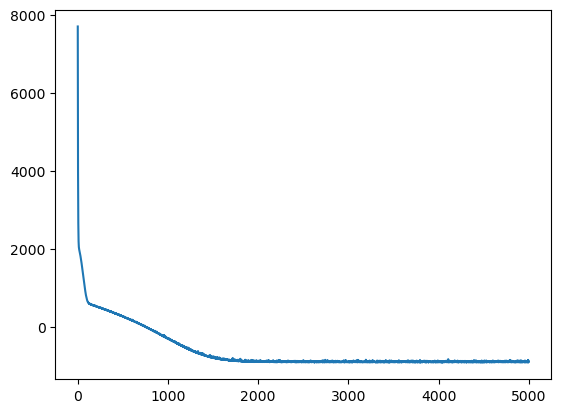

In [234]:
plt.plot(losses_train)

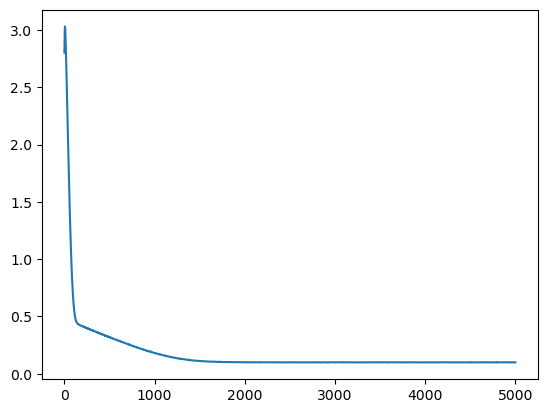

In [235]:
plt.plot(estimated_alpha)

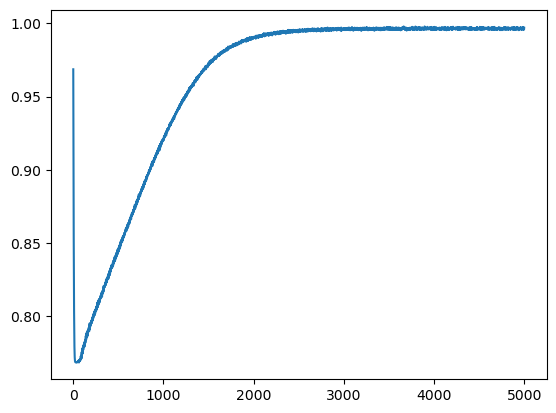

In [236]:
plt.plot(estimated_beta)

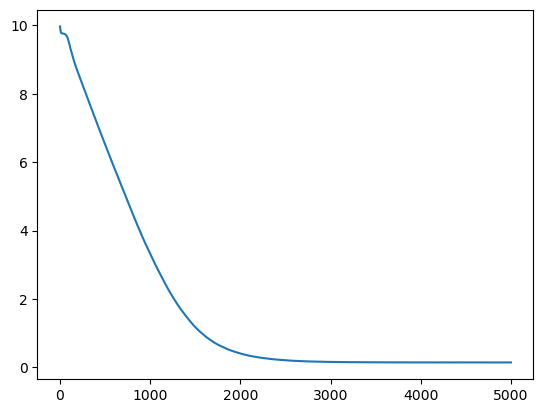

In [237]:
plt.plot(estimated_gamma)

In [238]:
print(f" C = {C} and gamma = {f.gamma.item()}")
print(f"B = {B} ansd beta = {f.beta.item()}")
print(f" alpha_inf = {alpha_inf} and alpha^2 estimated = {torch.exp(f.omega).item()**2}")
print(f" A  = {A} and alpha = {torch.exp(f.omega).item()}")

 C = 0.10473815461346635 and gamma = 0.14814139902591705
B = 0.9975062344139651 ansd beta = 0.9969621300697327
 alpha_inf = 1768.0 and alpha^2 estimated = 0.009878535034429925
 A  = 0.09987523388778448 and alpha = 0.09939081966876984


In [239]:
def visualisation(f, N):
    with torch.no_grad():
            
        fig, axs = plt.subplots(N)
        for n in range(N):
            x = true_x[n] #taking a true obs
            m = (mu0/sigma0**2 + x/sigma**2) * (1/sigma0**2 + 1/sigma**2)**(-1)
            s2 = (1/sigma0**2 + 1/sigma**2)**(-1)
            s = np.sqrt(s2)
            true_post = torch.distributions.Normal(torch.Tensor([m]), torch.Tensor([s]))
            true_theta = true_post.sample((10000,1))
            theta_hat = f.sample(x,(10000,1))
            sns.kdeplot(true_theta.detach().numpy().flatten(), ax=axs[n],color='b')
            sns.kdeplot(theta_hat.detach().numpy().flatten(), ax=axs[n],color='g')
            axs[n].axvline(m,color='purple')
            axs[n].set_title(f"Estimated and true densities of theta |x, run {n}")
    blue_patch = mpatches.Patch(color='b',label="True theta distribution | x")
    green_patch = mpatches.Patch(color='g',label='Estimated distribution of theta | x')
    fig.legend(handles=[blue_patch,green_patch], loc='upper right', bbox_to_anchor=(1.40, 1))
    fig.tight_layout()

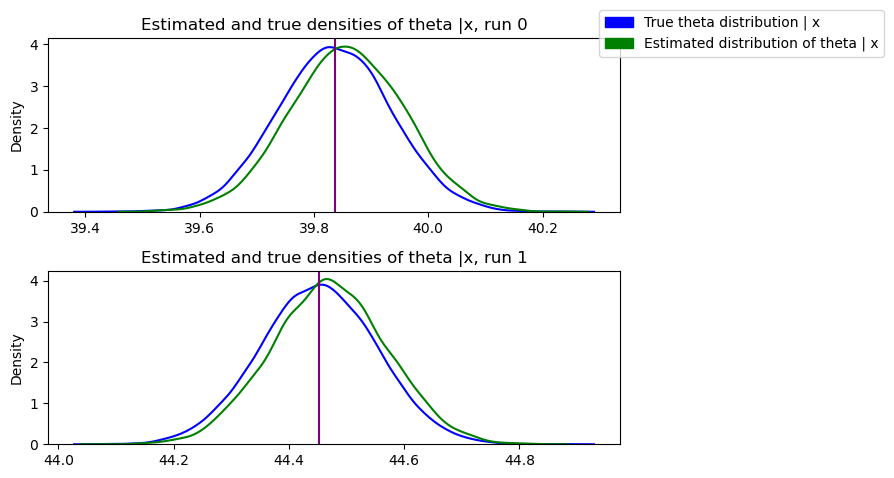

In [240]:
visualisation(f,2)

todo
Utiliser formules faisant intervenir theta simu & vrai theta ?
Comme ds intro papier ?
x


Nan en fait on sample du prior mais là dans ce cas précis on le connais donc cool sinon faire 2 classes (prior, likelihood) !!


faire avec logdet + logprob comme dans NF ? "in practive p(theta given x) is unknown